# Importing Modules

In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# Importing Dataset

In [ ]:
df_train = pd.read_csv("fashion-mnist_train.csv")
df_test = pd.read_csv("fashion-mnist_test.csv")

In [ ]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6,0,0,0,0,0,0,0,5,0,0,0,105,92,101,107,100,132,0,0,2,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,150,...,211,220,214,74,0,255,222,128,0,0,0,0,0,0,0,0,0,44,12,0,0,40,134,162,191,214,163,146,165,79,0,0,0,30,43,0,0,0,0,0
3,0,0,0,0,1,2,0,0,0,0,0,114,183,112,55,23,72,102,165,160,28,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,24,188,163,93,...,171,249,207,197,202,45,0,3,0,0,0,0,0,0,0,0,0,0,1,0,0,0,22,21,25,69,52,45,74,39,3,0,0,0,0,1,0,0,0,0
4,3,0,0,0,0,0,0,0,0,0,0,0,0,46,0,21,68,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,25,187,189,...,230,237,229,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,68,116,112,136,147,144,121,102,63,0,0,0,0,0,0,0,0,0,0


# Filtering Dataset For Binary Classification

Trouser is represented by 1, Pullover by 2, Updated Pullover encoding to 0



In [ ]:
df_train = df_train[(df_train.label==1) | (df_train.label==2)].reset_index(drop=True)
df_test = df_test[(df_test.label==1) | (df_test.label==2)].reset_index(drop=True)
df_train["label"] = df_train["label"].replace(2,0)
df_test["label"] = df_test["label"].replace(2,0)

# Binarizing The Data

In [ ]:
df_train[df_train.iloc[:,1:]>=126] = 255
df_train[df_train.iloc[:,1:]<126] = 0
df_test[df_test.iloc[:,1:]>=126] = 255
df_test[df_test.iloc[:,1:]<126] = 0

In [ ]:
df_train.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,pixel11,pixel12,pixel13,pixel14,pixel15,pixel16,pixel17,pixel18,pixel19,pixel20,pixel21,pixel22,pixel23,pixel24,pixel25,pixel26,pixel27,pixel28,pixel29,pixel30,pixel31,pixel32,pixel33,pixel34,pixel35,pixel36,pixel37,pixel38,pixel39,...,pixel745,pixel746,pixel747,pixel748,pixel749,pixel750,pixel751,pixel752,pixel753,pixel754,pixel755,pixel756,pixel757,pixel758,pixel759,pixel760,pixel761,pixel762,pixel763,pixel764,pixel765,pixel766,pixel767,pixel768,pixel769,pixel770,pixel771,pixel772,pixel773,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,...,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,...,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,0,0,255,255,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,255,255,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,255,255,255,255,255,255,255,255,255,255,0,0,0,0,0,0,0,0,0,0


# Seperating X and y

In [ ]:
y_train = df_train.iloc[:,0].values
X_train = df_train.iloc[:,1:].values
y_test = df_test.iloc[:,0].values
X_test = df_test.iloc[:,1:].values

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(12000, 784)
(2000, 784)
(12000,)
(2000,)


# Binary Classification Using Naive Bayes From Scratch

In [ ]:
class NaiveBayes:
  """
  Binary Classifier Using Gaussian Naive Bayes
  """
  def fit(self, X, y):
      self.stats = [np.zeros((2,784)),np.zeros((2,784)),np.zeros(2)]
      for i in range(0,2):
        self.stats[0][i] = X[y==i].mean(axis=0) #mean
        self.stats[1][i] = X[y==i].var(axis=0) #variance
        self.stats[2][i] = float(X[y==i].shape[0])/X.shape[0] #ratio of items of that class

  def predict(self, X):
      y_pred = []
      for row in X:

        prob = [] #storing probabilities
        for i in range(0,2):
          prob.append(np.log(self.stats[2][i])+np.sum(np.log(1e-8+self.pdf(i, row))))

        y_pred.append(np.argmax(prob)) #finding the class with max probability using argmax
      return np.array(y_pred)

  def pdf(self,index,row):
    """
    returns P(x = row | Ck= index)
    """
    mean = self.stats[0][index]
    var = self.stats[1][index] + 10
    return np.exp(-(np.square(row - mean)) / (2 * var))/np.sqrt(2 * np.pi * var)

# Classification Metrics

In [ ]:
class ClassificationMetrics:
  """
  Class for calculating classification metrics-Confusion Matrix, Accuracy, Recall,
  Precision
  """

  def __init__(self,y_test,y_pred):
    """
    Calculate the true negative, true postive, false negative and false postive
    values using y_pred and y_test
    """
    self.tn = 0
    self.tp = 0
    self.fp = 0
    self.fn = 0

    for i in range(len(y_test)):
      if y_test[i]==y_pred[i]:
        if y_test[i]:
          self.tp+=1
        else:
          self.tn+=1
      else:
        if y_test[i]:
          self.fn+=1
        else:
          self.fp+=1

  def confusion_matrix(self):
    """
    returns the confusion matrix in the form
    [
      [True Positive   False Positive]
      [False Negative  True Negative ]
    ]
    """
    return np.matrix([[self.tp,self.fp],[self.fn,self.tn]])

  def accuracy(self):
    """
    returns the accuracy given by (TP + TN)/(TP+TN+FP+FN)
    """
    try:
      return (self.tp+self.tn)/(self.tp+self.tn+self.fp+self.fn)
    except ZeroDivisionError:
      return 0.0

  def precision(self):
    """
    returns the precision given by (TP)/(TP+FP)
    """
    try:
      return self.tp/(self.tp+self.fp)
    except ZeroDivisionError:
      return 0.0

  def recall(self):
    """
    returns the recall given by TP/(TP+FN)
    """
    try:
      return self.tp/(self.tp+self.fn)
    except ZeroDivisionError:
      return 0.0

# Training the Model and Predicting Values

In [ ]:
naive_bayes = NaiveBayes()
naive_bayes.fit(X_train,y_train)
y_pred = naive_bayes.predict(X_test)
metrics = ClassificationMetrics(y_test,y_pred)
print("Confusion Matrix\n",metrics.confusion_matrix())
print("Accuracy ",metrics.accuracy())
print("Precision ",metrics.precision())
print("Recall ",metrics.recall())

Confusion Matrix
 [[967 120]
 [ 33 880]]
Accuracy  0.9235
Precision  0.889604415823367
Recall  0.967


# ROC Curve

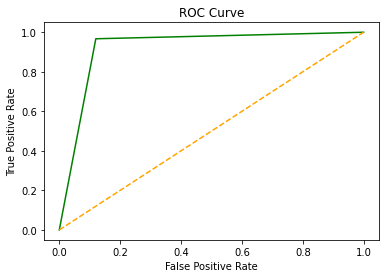

In [ ]:
fpr,tpr,thresholds = roc_curve(y_test,y_pred)
plt.plot(fpr, tpr,color='green')
plt.plot([0, 1], [0, 1], color='orange', linestyle='--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.show()

# K-Fold Cross Validation

In [ ]:
def k_fold_cross_validation(data,folds):
  """
  K-Fold Cross Validation is performed by splitting the dataset into k-folds and
   performing k-iterations. In each iteration, one of the k folds is taken as 
   the testing data and the remaining k-1 folds as the training and accuracy is 
   calculated. The average of the accuracy from the k folds is returned. 
  """

  data_copy = np.array(data)
  fold_size = len(data)//folds
  accuracy = 0
  for i in range(folds):
    test = data_copy[i*fold_size:(i+1)*fold_size]
    train = np.concatenate((data_copy[:i*fold_size],data_copy[(i+1)*fold_size:]))

    test = pd.DataFrame(test)
    train = pd.DataFrame(train)

    y_train = train.iloc[:,0].values
    X_train = train.iloc[:,1:].values
    y_test = test.iloc[:,0].values
    X_test = test.iloc[:,1:].values

    naive_bayes = NaiveBayes()
    naive_bayes.fit(X_train,y_train)
    y_pred = naive_bayes.predict(X_test)

    metrics = ClassificationMetrics(y_test,y_pred)
    score= metrics.accuracy()
    accuracy+=score
  return accuracy/folds


In [ ]:
data = df_train.append(df_test)
print("Accuracy Using K-Fold Cross Validation: ",k_fold_cross_validation(data,5))

Accuracy Using K-Fold Cross Validation:  0.9217857142857142
